In [33]:
import pandas as pd
import numpy as np
import nltk
from matplotlib import pyplot as plt
%matplotlib inline

### Autoselecting genes related to cancer

In [2]:
with open('stopwords.txt', 'r') as f:
    stops = f.readlines()

In [3]:
sentences =pd.read_csv('genesdf')

In [4]:
sentences=sentences.drop(['Unnamed: 0'],axis=1)
sentences.head()

,symbol,blurb,match
0,TP53,This gene encodes a tumor suppressor protein c...,0
1,EGFR,The protein encoded by this gene is a transmem...,0
2,TNF,This gene encodes a multifunctional proinflamm...,0
3,APOE,The protein encoded by this gene is a major ap...,0
4,VEGFA,This gene is a member of the PDGF/VEGF growth ...,0


In [5]:
import re

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
STOPWORDS = stops
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text

In [6]:
sentences['blurbtext']=sentences['blurb'].apply(lambda x: str(x).lower())
sentences['blurbtext']=sentences['blurbtext'].apply(lambda x: clean_text(x))
#sentences['blurbsplit']=sentences['blurbtext'].apply(lambda x: str(x).split('.')[0])

In [7]:
len(sentences['blurbtext'][0])

761

In [8]:
test="I don't have myeloma."

In [9]:
pd.Series(test).str.contains('tumor|\w*oma\W')

0    True
dtype: bool

In [10]:
sentences['predict'] = sentences['blurbtext'].str.contains('tumor|cancer|leukemia|\w*oma\W')

In [11]:
len(sentences)

1292

In [12]:
len(sentences[sentences['predict']==1])

363

In [15]:
lenblurb=[len(x.split()) for x in sentences['blurbtext']]
maxlen=max(lenblurb)
print('max sequence')
maxlen

max sequence


298

In [16]:
#make words into one-hot-vectors

def make_vector(word,vocab):
    lenvocab=len(vocab)
    blurbV=[]

    vector=np.zeros(lenvocab)
    vector[vocab.index(word)]=1

    return vector

    

In [17]:
#for i in blurbs.columns:
    #blurbs[i]=blurbs[i].apply(lambda x: make_vector('tumor',vocab) if x==x else np.zeros(len(vocab)))

In [19]:
from keras.preprocessing.text import Tokenizer
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 2000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 298
# This is fixed.
EMBEDDING_DIM = 1000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(sentences['blurbtext'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 7118 unique tokens.


In [21]:
from keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(sentences['blurbtext'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1292, 298)


In [22]:
X

array([[   0,    0,    0, ...,   12,  310,  140],
       [   0,    0,    0, ...,   12,  323,  140],
       [   0,    0,    0, ...,   12,   36,   43],
       ...,
       [   0,    0,    0, ...,    8, 1206,   89],
       [   0,    0,    0, ...,    8, 1206,   89],
       [   0,    0,    0, ...,   12,  296,  119]], dtype=int32)

In [23]:
#X=blurbs
y=np.array(sentences['predict'])
#you can use get_dummies if y is not binary
#print('Shape of data tensor:', X.shape)
#print('Shape of label tensor:', y.shape)

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1162, 298) (1162,)
(130, 298) (130,)


In [25]:
from random import randint
from numpy import array
from numpy import argmax
from pandas import DataFrame

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers.core import Dense, SpatialDropout1D
from keras.callbacks import EarlyStopping

In [26]:
X_train.shape[1]

298

In [27]:
epochs = 5
batch_size = 16
EMBEDDING_DIM=1000
model = Sequential()
model.add(Embedding(MAX_NB_WORDS,EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(1500, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1045 samples, validate on 117 samples
Epoch 1/5





1045/1045 [==============================] - 504s 483ms/step - loss: 0.6146 - acc: 0.7129 - val_loss: 0.6469 - val_acc: 0.6752
Epoch 2/5
1045/1045 [==============================] - 488s 467ms/step - loss: 0.5689 - acc: 0.7349 - val_loss: 0.6087 - val_acc: 0.6752
Epoch 3/5
1045/1045 [==============================] - 485s 464ms/step - loss: 0.5677 - acc: 0.7397 - val_loss: 0.6336 - val_acc: 0.6752
Epoch 4/5
1045/1045 [==============================] - 481s 460ms/step - loss: 0.5154 - acc: 0.7550 - val_loss: 0.5312 - val_acc: 0.6838
Epoch 5/5
1045/1045 [==============================] - 482s 462ms/step - loss: 0.2293 - acc: 0.9292 - val_loss: 0.2570 - val_acc: 0.9145


In [28]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

130/130 [==============================] - 8s 58ms/step
Test set
  Loss: 0.189
  Accuracy: 0.938


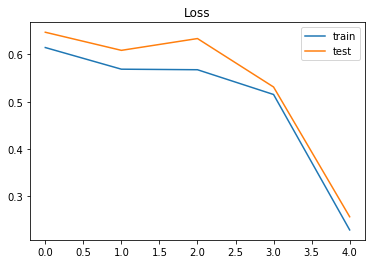

In [34]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

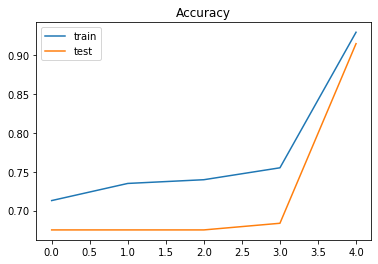

In [35]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

### Loss is dropping but not converging and the accuracy curve suggests that there isn't a problem with overfitting. I could run the model longer and see how it does.